## Imports

In [ ]:
from IPython.display import clear_output
!pip install sktime
clear_output()

In [ ]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import imageio
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
import re 
import math
import gc
import csv
import time
import pickle
import os

from pathlib import Path 
from zipfile import ZipFile
from PIL import Image
from sktime.datasets import load_from_tsfile_to_dataframe
from sklearn.model_selection import KFold

from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, MaxPooling2D, Flatten, Dense, InputLayer, BatchNormalization, Dropout
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras

## Functions

In [ ]:
def get_model_name(k):
    return 'model_'+str(k)+'.h5'

In [ ]:
def pureBlackAndWhiteImageArrayUpdated( imageArray, normalized = True):
  aux = imageArray != 0
  result = aux.astype("uint8")[:,:,:1]
  return result if normalized else (result*255)

In [ ]:
def get_order(file):
    match = re.compile(r'.*?(\d+).*?').match(Path(file).name)
    if not match:
        return math.inf
    return int(match.groups()[0])

In [ ]:
def get_model(width, height, channels):
  model = Sequential()

  model.add(Conv2D(16, (1, 1), activation='relu', input_shape=(width, height, channels)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(32, (1, 1), activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (1, 1), activation='relu'))

  model.add(Flatten())

  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.7)) #Aumentar depois maybe o dropout
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.7))
  model.add(Dense(n_classes, activation='softmax'))

  # early stopping
  callback = EarlyStopping(monitor='loss')
  # compile model
  opt = keras.optimizers.Adam(learning_rate=0.0001)

  model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  
  return model

In [ ]:
def get_model2(width, height, channels):
  # define model
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(width, height, channels)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(64, activation='relu'))
  model.add(Dense(n_classes, activation='softmax'))
  # early stopping
  callback = EarlyStopping(monitor='loss', patience=3)
  # compile model
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

## Run code

### Configs

In [ ]:
from google.colab import drive
# drive.flush_and_unmount()
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_SET_NAMES = [
"ACSF1",
"Adiac",
"ArrowHead",
"Beef",
"BeetleFly",
"BirdChicken",
"BME",
"Car",
"CBF",
"Chinatown",
"ChlorineConcentration",
"CinCECGtorso",
"Coffee",
"Computers",
"Crop",
"DiatomSizeReduction",
"DistalPhalanxOutlineAgeGroup",
"DistalPhalanxOutlineCorrect",
"DistalPhalanxTW",
"Earthquakes",
"ECG200",
"ECG5000",
"ECGFiveDays",
"ElectricDevices",
"EthanolLevel",
"FaceAll",
"FaceFour",
"FacesUCR",
"FiftyWords",
"Fish",
"FordA",
"FordB",
"FreezerRegularTrain",
"FreezerSmallTrain",
"GunPoint",
"GunPointAgeSpan",
"GunPointMaleVersusFemale",
"GunPointOldVersusYoung",
"Ham",
"Haptics",
"Herring",
"HouseTwenty",
"InlineSkate",
"InsectEPGRegularTrain",
"InsectEPGSmallTrain",
"ItalyPowerDemand",
"LargeKitchenAppliances",
"Lightning2",
"Lightning7",
"Mallat",
"Meat",
"MedicalImages",
"MiddlePhalanxOutlineAgeGroup",
"MiddlePhalanxOutlineCorrect",
"MiddlePhalanxTW",
"MixedShapesRegularTrain",
"MixedShapesSmallTrain",
"MoteStrain",
"OliveOil",
"OSULeaf",
"PhalangesOutlinesCorrect",
"Phoneme",
"PigAirwayPressure",
"PigArtPressure",
"PigCVP",
"Plane",
"ProximalPhalanxOutlineAgeGroup",
"ProximalPhalanxOutlineCorrect",
"ProximalPhalanxTW",
"Rock",
"ScreenType",
"SemgHandGenderCh2",
"SemgHandMovementCh2",
"SemgHandSubjectCh2",
"ShapeletSim",
"ShapesAll",
"SmallKitchenAppliances",
"SmoothSubspace",
"SonyAIBORobotSurface1",
"SonyAIBORobotSurface2",
"StarLightCurves",
"Strawberry",
"SwedishLeaf",
"Symbols",
"SyntheticControl",
"ToeSegmentation1",
"ToeSegmentation2",
"Trace",
"TwoLeadECG",
"TwoPatterns",
"UMD",
"UWaveGestureLibraryAll",
"Wafer",
"Wine",
"WordSynonyms",
"Worms",
"WormsTwoClass",
"Yoga"]

In [ ]:
print(len(DATA_SET_NAMES))
DATA_SET_NAMES.index("UWaveGestureLibraryAll")

98


91

### Import some data zipped

In [ ]:
file_name = '/content/drive/MyDrive/5_boxplots.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


### Create CSV

In [ ]:
# csv_name = '10_boxplots_results.csv'

# pd.DataFrame(
#     columns=
#         ['Dataset',
#          'Fold 1: Acc','Fold 1: Loss',
#          'Fold 2: Acc','Fold 2: Loss',
#          'Fold 3: Acc','Fold 3: Loss',
#          'Fold 4: Acc','Fold 4: Loss',
#          'Fold 5: Acc','Fold 5: Loss',
#          'Average: Acc','Average: Loss',
#          'Standard Deviation',
#          'batch_size', 'epochs', 'ExecutionTime']
#          ).to_csv(csv_name, index = False, header = True)

### Script

In [ ]:
for name in DATA_SET_NAMES[2:3]:

  ################# CONFIGS #################
  print("Using: ", name)

  start_time = time.time()
  
  numberOfPlots = 5
  normalized = False 

  #plots = "Violinplots" 
  #plots = "Boxplots" 
  plots = "DeepInisight"
  pathName = '/content/' + str(numberOfPlots) + '_' + plots.lower() + '/'

  train_x = []
  test_x = []

  ################# LOAD DATASET #################

  _, train_y = load_from_tsfile_to_dataframe("drive/MyDrive/Tese/Univariate_ts/" + name + "/" + name + "_TRAIN.ts")
  _, test_y = load_from_tsfile_to_dataframe("drive/MyDrive/Tese/Univariate_ts/" + name + "/" + name + "_TEST.ts")

  train_x = np.empty((len(train_y), 288, 432, 1), dtype=np.uint8)
  test_x = np.empty((len(test_y), 288, 432, 1), dtype=np.uint8)

  trainOrTest = 'TRAIN'
  path = pathName + name + '/' + trainOrTest + '/' + '*.png*'

  for i, img_path in enumerate(sorted(glob.glob(path), key=get_order)):
    train_x[i] = pureBlackAndWhiteImageArrayUpdated(cv2.imread(img_path), normalized = normalized)

  trainOrTest = 'TEST'
  path = pathName + name + '/' + trainOrTest + '/' + '*.png*'

  for i, img_path in enumerate(sorted(glob.glob(path), key=get_order)):
    test_x[i] = pureBlackAndWhiteImageArrayUpdated(cv2.imread(img_path), normalized = normalized)

  ################# PREPARE DATA #################

  train_y = train_y.astype('uint8')
  test_y = test_y.astype('uint8')

  while(min(train_y) > 0):
    train_y = train_y - 1
  while(min(test_y) > 0):
    test_y = test_y - 1

  n_classes = np.unique(train_y).size
  train_length, width, height, channels = train_x.shape[0], train_x.shape[1], train_x.shape[2], train_x.shape[3]

  print("train_length:", train_length, " width:", width, " height:", height, " channels:", channels)
  datagen = ImageDataGenerator(rescale=1.0/255.0)

  ################# TRAINING #################

  #Configs
  #BATCH_SIZE = 32 if train_length >= 500 else 16 if train_length >= 50 else 8
  BATCH_SIZE = 16 if train_length >= 50 else 8
  EPOCHS = 100#################################################################################################### MUDAR DEPOIS ##########
  N_SPLIT = 5
  verbose = 1

  # Storing the average of all predictions
  main_pred = []
  data_kfold = pd.DataFrame()
  acc_per_fold = []
  loss_per_fold = []
  row = []
  row.append(name)

  kfold = KFold(n_splits=N_SPLIT, shuffle=True)

  fold_no = 0

  for train_idx, val_idx in list(kfold.split(train_x, train_y)):

      #if os.path.exists("bestModel.hdf5"):
      #  print("REMOVED")
      #  os.remove("bestModel.hdf5")

      fold_no+=1

      training_set = datagen.flow(train_x[train_idx], train_y[train_idx], batch_size=BATCH_SIZE)
      
      validation_set = datagen.flow(train_x[val_idx], train_y[val_idx], batch_size=BATCH_SIZE)

      model_test = get_model(width, height, channels)

      callbacks = [
      # keras.callbacks.ReduceLROnPlateau(
      #     monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
      #),
      # keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),

      # keras.callbacks.CSVLogger("history.csv", separator=",", append=True)
      # keras.callbacks.ModelCheckpoint("bestModel.hdf5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min')
      #  keras.callbacks.ModelCheckpoint("/content/bestModel.hdf5",
      #                                  monitor='val_accuracy',
      #                                  verbose=1,
      #                                  save_best_only=True,
      #                                 save_weights_only=True,
      #                                 mode='max')
        #keras.callbacks.ModelCheckpoint("/saved_models/model.h5", 
      #				monitor='val_accuracy', verbose=1, 
      #				save_best_only=True, save_weights_only=True, mode='max')
          keras.callbacks.ModelCheckpoint("/saved_models/model.h5", 
              monitor='val_loss', verbose=1, 
              save_best_only=True, save_weights_only=True, mode='min')
      ]

      history = model_test.fit( training_set,
                                validation_data=validation_set,
                                epochs = EPOCHS,
                                steps_per_epoch = len(training_set) ,
                                callbacks = callbacks,
                                verbose = verbose
                                )
      
      with open('/trainHistoryDict', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

      del(training_set)
      del(validation_set)

      test_set = datagen.flow(test_x, test_y, batch_size=BATCH_SIZE)

      #model_test = get_model(width, height, channels)
      #model_test.load_weights("/saved_models/model_"+str(fold_no)+".h5")
      model_test.load_weights("/saved_models/model.h5")
      pred = model_test.evaluate(test_set, steps=len(test_set))

      del(test_set)

      print(f'Score for fold {fold_no}: {model_test.metrics_names[0]} of {pred[0]}; {model_test.metrics_names[1]} of {pred[1]*100}%')
      
      acc_per_fold.append(pred[1])
      loss_per_fold.append(pred[0])
      

      keras.backend.clear_session()
      gc.collect()


  ################# OUTPUT #################


  # == Provide average scores ==
  print('------------------------------------------------------------------------')
  print('Score per fold')
  for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i] * 100}%')
    row.append(acc_per_fold[i])
    row.append(loss_per_fold[i])

  print('------------------------------------------------------------------------')
  print('Average scores for all folds:')
  print(f'> Accuracy: {np.mean(acc_per_fold) * 100} (+- {np.std(acc_per_fold) * 100})')
  print(f'> Loss: {np.mean(loss_per_fold)}')
  print('------------------------------------------------------------------------')

  row.append(np.mean(acc_per_fold))
  row.append(np.mean(loss_per_fold))
  row.append(np.std(acc_per_fold))
  
  row.append(BATCH_SIZE)
  row.append(EPOCHS)

  row.append(time.time() - start_time)


  ################# SAVE DATA #################

  # with open(csv_name, 'a') as f:
  #    writer = csv.writer(f)
  #    writer.writerow(row)

  del(row, main_pred, data_kfold, acc_per_fold, loss_per_fold, datagen)
  del(train_x, test_x)
  gc.collect()

Using:  ArrowHead
train_length: 36  width: 288  height: 432  channels: 1


KeyboardInterrupt: ignored

Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.0465044975280762 - Accuracy: 58.28571319580078%
------------------------------------------------------------------------
> Fold 2 - Loss: 1.0465046167373657 - Accuracy: 58.28571319580078%
------------------------------------------------------------------------
> Fold 3 - Loss: 1.0465046167373657 - Accuracy: 58.28571319580078%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.9877400398254395 - Accuracy: 60.57142615318298%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.9877400398254395 - Accuracy: 60.57142615318298%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 59.19999837875366 (+- 1.1197660888108614)
> Loss: 1.0229987621307373
------------------------------------------------------------------------


Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.0004421472549438 - Accuracy: 56.00000023841858%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.8281406760215759 - Accuracy: 63.999998569488525%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.7408023476600647 - Accuracy: 65.14285802841187%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.9091747999191284 - Accuracy: 56.00000023841858%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.9367730021476746 - Accuracy: 58.28571319580078%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 59.885714054107666 (+- 3.932491482546975)
> Loss: 0.8830665946006775

Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.0767014026641846 - Accuracy: 34.857141971588135%
------------------------------------------------------------------------
> Fold 2 - Loss: 1.0528483390808105 - Accuracy: 47.42857217788696%
------------------------------------------------------------------------
> Fold 3 - Loss: 1.051399827003479 - Accuracy: 58.28571319580078%
------------------------------------------------------------------------
> Fold 4 - Loss: 1.000044584274292 - Accuracy: 65.71428775787354%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.9227733612060547 - Accuracy: 59.42857265472412%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 53.14285755157471 (+- 10.872170782058719)
> Loss: 1.0207535028457642

Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.9387332797050476 - Accuracy: 67.42857098579407%
------------------------------------------------------------------------
> Fold 2 - Loss: 1.013399362564087 - Accuracy: 54.85714077949524%
------------------------------------------------------------------------
> Fold 3 - Loss: 1.0478737354278564 - Accuracy: 45.14285624027252%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.9828703999519348 - Accuracy: 62.85714507102966%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.9072092771530151 - Accuracy: 62.85714507102966%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 58.62857162952423 (+- 7.864983987106529)
> Loss: 0.9780172109603882

Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.8276019096374512 - Accuracy: 64.5714282989502%
------------------------------------------------------------------------
> Fold 2 - Loss: 1.0709792375564575 - Accuracy: 47.999998927116394%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.770380973815918 - Accuracy: 63.999998569488525%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.9075494408607483 - Accuracy: 57.71428346633911%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.8119934797286987 - Accuracy: 62.28571534156799%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 59.31428492069244 (+- 6.1481044207550966)
> Loss: 0.8777010083198548

## History

Index(['epoch', 'accuracy', 'loss', 'lr', 'val_accuracy', 'val_loss'], dtype='object')


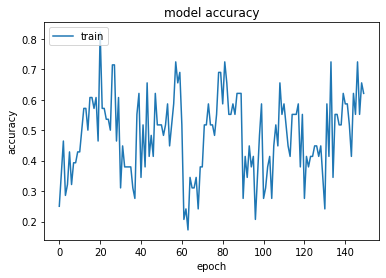

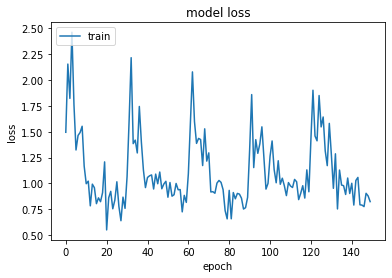

In [ ]:
data = pd.read_csv('history.csv')
# list all data in history
print(data.keys())
# summarize history for accuracy
plt.plot(data['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(data['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
data.loc[0]

epoch           0.000000
accuracy        0.250000
loss            1.495055
lr              0.000100
val_accuracy    0.375000
val_loss        1.151473
Name: 0, dtype: float64

[29, 59, 89, 119, 149]


## Checkpoint Test

## Read csv Logs

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv (r'Computers.csv')

In [ ]:
print(data)

      epoch  accuracy      loss  val_accuracy  val_loss
0         0     0.550  0.850673          0.52  0.691331
1         1     0.530  0.839566          0.50  0.723606
2         2     0.550  0.784009          0.54  0.659643
3         3     0.505  0.751615          0.58  0.668494
4         4     0.580  0.691679          0.66  0.672287
...     ...       ...       ...           ...       ...
1245    245     0.980  0.069159          0.70  2.154168
1246    246     0.965  0.058883          0.68  2.173145
1247    247     0.945  0.086359          0.66  2.286667
1248    248     0.945  0.115194          0.68  2.321953
1249    249     0.960  0.107340          0.72  1.927128

[1250 rows x 5 columns]


In [ ]:
index = data.index

condition = data["epoch"] == 249 #NUMBER OF EPOACHS

epoch_indices = index[condition]

epoch_indices_list = epoch_indices.tolist()

print(epoch_indices_list)

[249, 499, 749, 999, 1249]


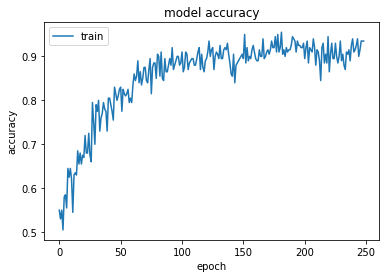

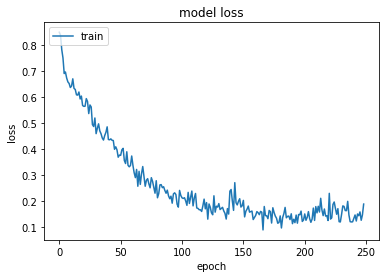

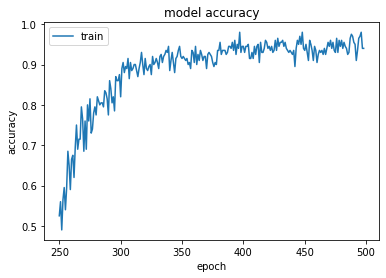

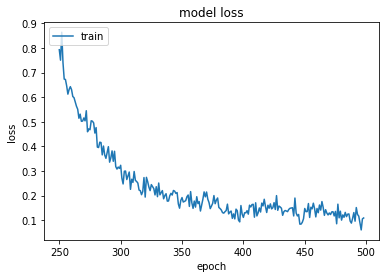

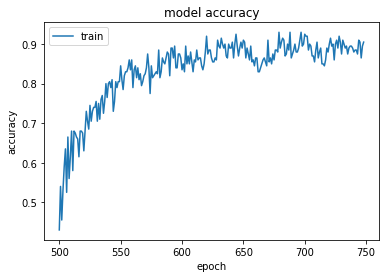

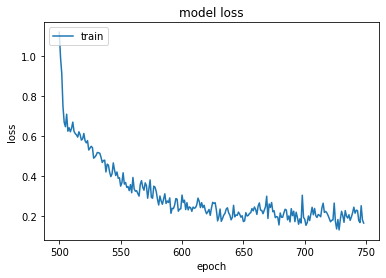

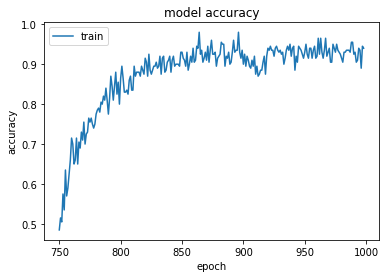

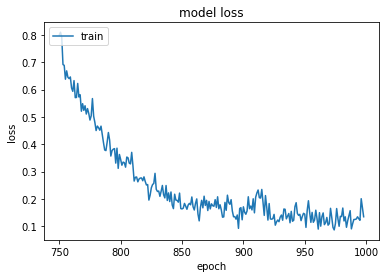

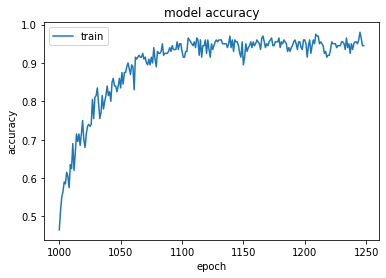

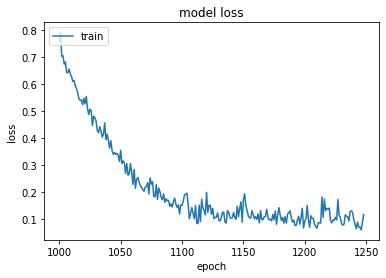

In [ ]:
count = 0
for indice in epoch_indices_list:
  # summarize history for accuracy
  plt.plot(data['accuracy'][count:indice])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(data['loss'][count:indice])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  count = indice + 1

# Plot architecture

In [ ]:
from keras.utils.vis_utils import plot_model

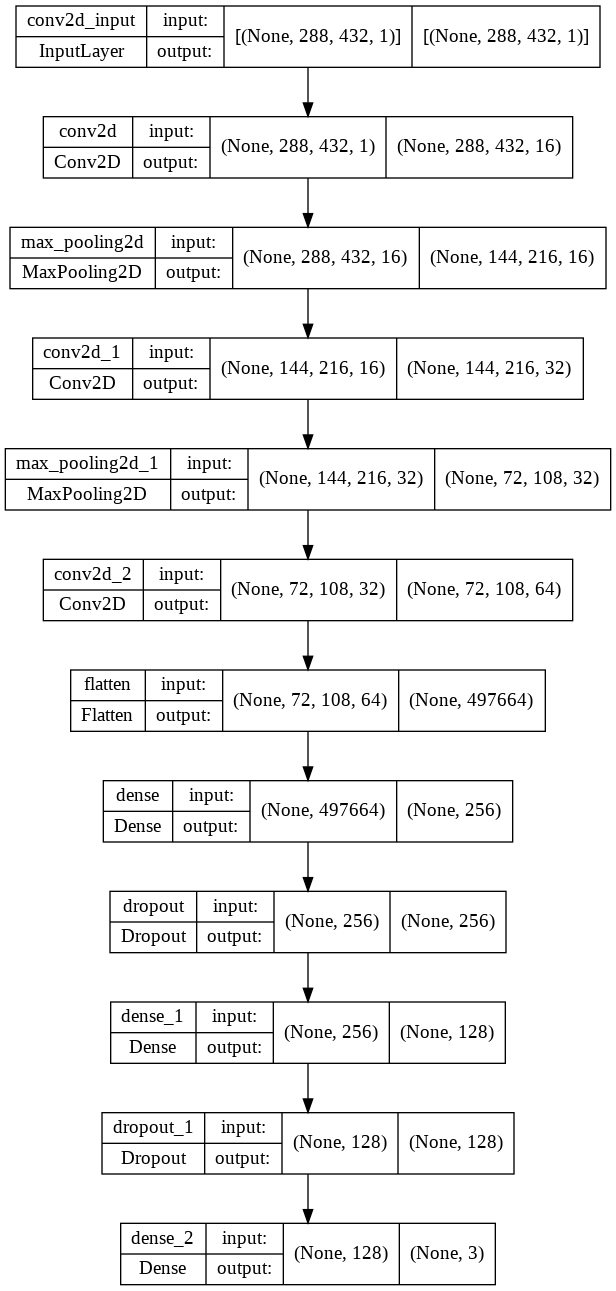

In [ ]:
train_length = 36  
width = 288  
height = 432
channels = 1
model_test = get_model(width, height, channels)
plot_model(model_test, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Loop

In [ ]:
while True:pass